In [ ]:
#| default_exp sgd

In [ ]:
#|export
import torch
import fastcore.all as fc

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)

import logging
logging.disable(logging.WARNING)

set_seed(1103)
     

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
cbs = [DeviceCB(), stats, ProgressCB(plot=True), MetricsCB(accuracy=MulticlassAccuracy())]
leak = 0.1
act_init = partial(GeneralReLU, leak=leak, sub=0.5)
init_w = partial(init_weights, leak=leak)

# SGD

In [ ]:
class SGD:
    def __init__(self, params, lr=0.1, wd=0.0):
        self.params = list(params)
        self.lr = lr
        self.wd = wd

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd > 0:
            p *= p * (1 - self.wd)

    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

accuracy,loss,epoch,train
0.759,0.684,0,train
0.808,0.534,0,valid
0.833,0.463,1,train
0.831,0.466,1,valid
0.851,0.413,2,train
0.846,0.428,2,valid


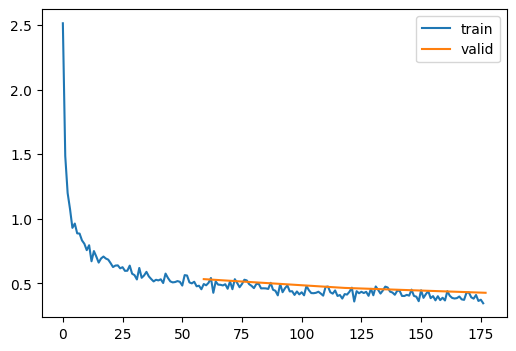

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.15, cbs=cbs, opt_func=SGD)
learn.fit(3)

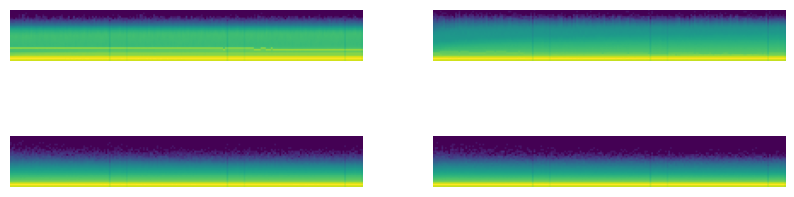

In [ ]:
stats.color_dim()

## Momentum

In [ ]:
class SGD:
    def __init__(self, params, lr=0.1, wd=0.0):
        self.params = list(params)
        self.lr = lr
        self.wd = wd

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd > 0:
            p *= p * (1 - self.wd)

    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()

In [ ]:
torch.lerp(tensor(1.), tensor(2.), 0.2)

tensor(1.20)

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, mom=0.8):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, "grad_avg"):
            p.grad_avg = torch.zeros_like(p.grad)

        p.grad_avg = torch.lerp(p.grad, p.grad_avg, self.mom)
        p -= p.grad_avg * self.lr

accuracy,loss,epoch,train
0.785,0.594,0,train
0.840,0.443,0,valid
0.860,0.384,1,train
0.854,0.398,1,valid
0.875,0.342,2,train
0.858,0.394,2,valid


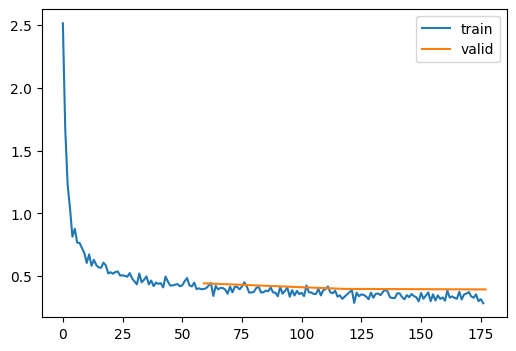

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.5, cbs=cbs, opt_func=Momentum)
learn.fit(3)

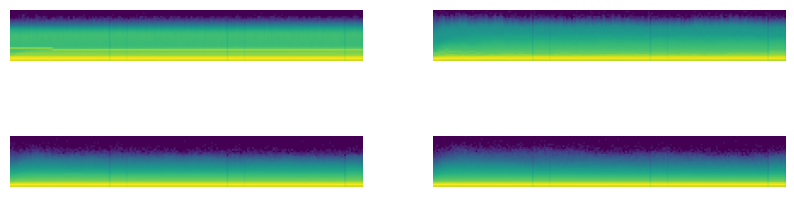

In [ ]:
stats.color_dim()

# RMSProp

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, mom=0.8, eps=1e-4):
        super().__init__(params, lr, wd)
        self.mom = mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, "grad_sq_avg"):
            # p.grad_sq_avg = torch.zeros_like(p.grad)
            p.grad_sq_avg = p.grad ** 2
        p.grad_sq_avg = torch.lerp(p.grad ** 2, p.grad_sq_avg, self.mom)
        p -= self.lr * p.grad / (p.grad_sq_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.747,0.721,0,train
0.824,0.500,0,valid
0.848,0.406,1,train
0.848,0.419,1,valid
0.874,0.336,2,train
0.850,0.424,2,valid


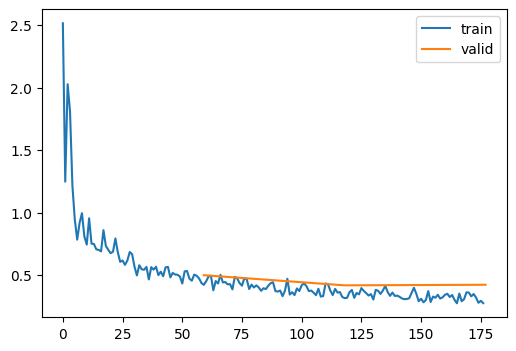

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

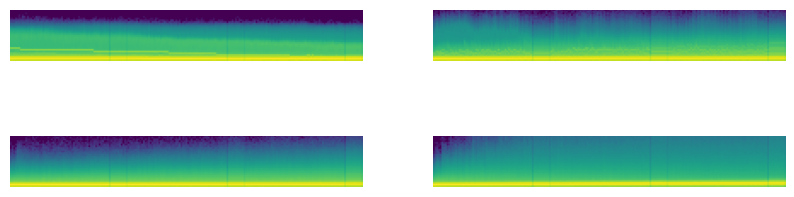

In [ ]:
stats.color_dim()

# Adam

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, mom=0.8, eps=1e-4):
        super().__init__(params, lr, wd)
        self.mom = mom
        self.eps = eps

    def opt_step(self, p):
        if not hasattr(p, "grad_sq_avg"):
            # p.grad_sq_avg = torch.zeros_like(p.grad)
            p.grad_sq_avg = p.grad ** 2
        p.grad_sq_avg = torch.lerp(p.grad ** 2, p.grad_sq_avg, self.mom)
        p -= self.lr * p.grad / (p.grad_sq_avg.sqrt() + self.eps)

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr=0.1, wd=0.0, beta1=0.9, beta2=0.999, eps=1e-4):
        super().__init__(params, lr, wd)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.step_idx = 0

    def step(self):
        self.step_idx += 1
        super().step()

    def opt_step(self, p):
        if not hasattr(p, "grad_sq_avg"):
            p.grad_sq_avg = torch.zeros_like(p.grad)
            p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = torch.lerp(p.grad, p.grad_avg, self.beta1)
        p.grad_sq_avg = torch.lerp(p.grad ** 2, p.grad_sq_avg, self.beta2)
        unbiased_avg = p.grad_avg / (1 - self.beta1 ** self.step_idx)
        unbiased_sq_avg = p.grad_sq_avg / (1 - self.beta2 ** self.step_idx)

        p -= self.lr * unbiased_avg / (unbiased_sq_avg.sqrt() + self.eps)

accuracy,loss,epoch,train
0.803,0.538,0,train
0.853,0.403,0,valid
0.874,0.344,1,train
0.869,0.367,1,valid
0.889,0.301,2,train
0.878,0.336,2,valid


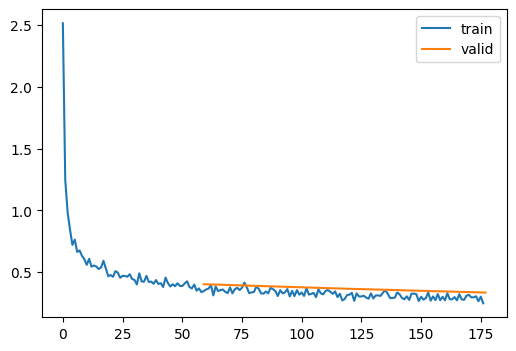

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs, opt_func=Adam)
learn.fit(3)

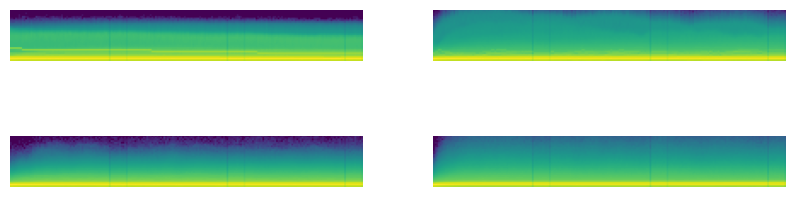

In [ ]:
stats.color_dim()

# Schedulers

In [ ]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.01, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [ ]:
opt = learn.opt
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
ps = list(learn.model.parameters())

In [ ]:
opt_st = opt.state

In [ ]:
p_st = opt_st[ps[0]]

In [ ]:
p_st

{'momentum_buffer': None}

In [ ]:
pgs = opt.param_groups
pgs[0].keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach', 'differentiable'])

In [ ]:
lr_scheduler.CosineAnnealingLR?

Init signature:
lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max,
    eta_min=0,
    last_epoch=-1,
    verbose=False,
)
Docstring:     
Set the learning rate of each parameter group using a cosine annealing
schedule, where :math:`\eta_{max}` is set to the initial lr and
:math:`T_{cur}` is the number of epochs since the last restart in SGDR:

.. math::
    \begin{aligned}
        \eta_t & = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1
        + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right),
        & T_{cur} \neq (2k+1)T_{max}; \\
        \eta_{t+1} & = \eta_{t} + \frac{1}{2}(\eta_{max} - \eta_{min})
        \left(1 - \cos\left(\frac{1}{T_{max}}\pi\right)\right),
        & T_{cur} = (2k+1)T_{max}.
    \end{aligned}

When last_epoch=-1, sets initial lr as lr. Notice that because the schedule
is defined recursively, the learning rate can be simultaneously modified
outside this scheduler by other operators. If the learning rate is set
solely by this scheduler, the

In [ ]:
sched = lr_scheduler.CosineAnnealingLR(opt, 50)

In [ ]:
print(list(filter(lambda x: x[0]!="_", dir(sched))))

['T_max', 'base_lrs', 'eta_min', 'get_last_lr', 'get_lr', 'last_epoch', 'load_state_dict', 'optimizer', 'print_lr', 'state_dict', 'step', 'verbose']


In [ ]:
sched.base_lrs, sched.get_last_lr()

([0.01], [0.01])

[<matplotlib.lines.Line2D>]

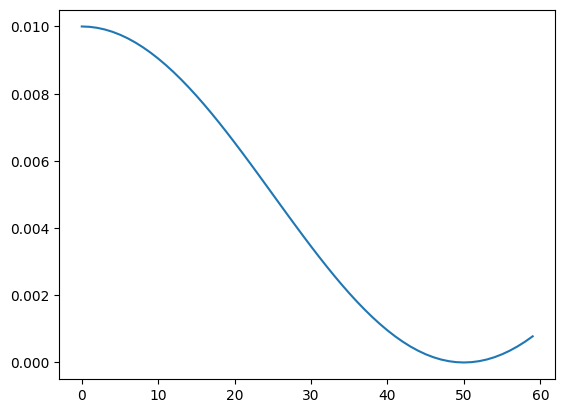

In [ ]:
lrs = []
for i in range(60):
    lrs.append(sched.get_last_lr()[0])
    sched.optimizer.step()
    sched.step()

plt.plot(range(60), lrs)

## Scheduler callbacks

In [ ]:
#| export
class BaseSchedCB(Callback):
    def __init__(self, sched): fc.store_attr()

    def before_fit(self, learn):
        self.sched_instance = self.sched(learn.opt)

    def _step(self, learn):
        if learn.training:
            self.sched_instance.step()

In [ ]:
#| export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn):
        self._step(learn)

In [ ]:
#| export
class HasLearnCB(Callback):
    def before_fit(self, learn):
        self.learn = learn

    def after_fit(self, learn):
        self.learn = None

In [ ]:
#| export
class RecorderCB(Callback):
    def __init__(self, **d):
        self.d = d

    def before_fit(self, learn):
        self.recorded = {k: [] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if learn.training:
            for k, v in self.d.items():
                self.recorded[k].append(v(self.pg))

    def plot(self):
        for k, vs in self.recorded.items():
            plt.plot(range(len(vs)), vs, label=k)
            plt.legend()
            plt.show()

In [ ]:
def get_lr(pg):
    return pg["lr"]

In [ ]:
epochs = 3
tmax = len(dls.train) * epochs
sched = BatchSchedCB(partial(lr_scheduler.CosineAnnealingLR, T_max=tmax))
record = RecorderCB(lr=get_lr)

accuracy,loss,epoch,train
0.803,0.538,0,train
0.855,0.400,0,valid
0.876,0.340,1,train
0.871,0.357,1,valid
0.892,0.297,2,train
0.875,0.344,2,valid


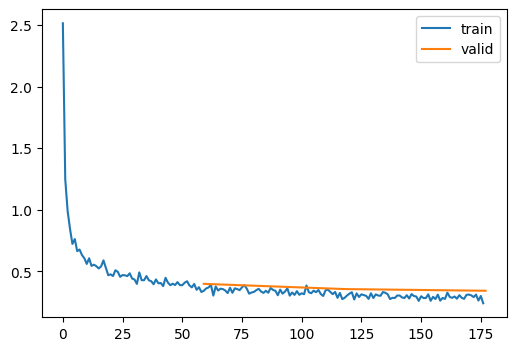

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs+[sched, record], opt_func=optim.AdamW)
learn.fit(epochs)

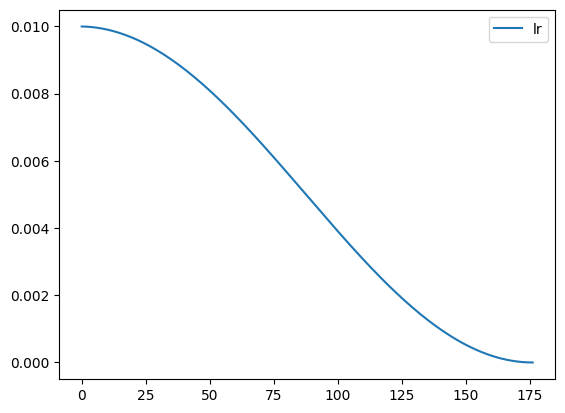

In [ ]:
record.plot()

In [ ]:
#| export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn):
        self._step(learn)

In [ ]:
epochs = 3
tmax = epochs
sched = EpochSchedCB(partial(lr_scheduler.CosineAnnealingLR, T_max=tmax))
record = RecorderCB(lr=get_lr)

accuracy,loss,epoch,train
0.803,0.537,0,train
0.853,0.399,0,valid
0.876,0.340,1,train
0.869,0.362,1,valid
0.894,0.289,2,train
0.876,0.335,2,valid


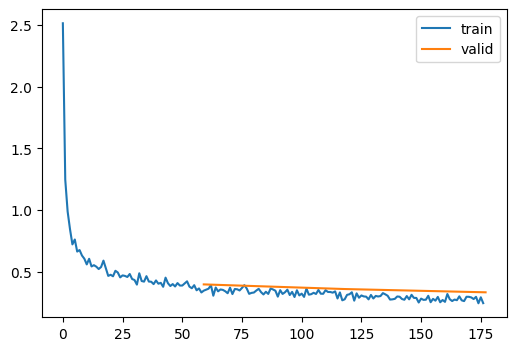

In [ ]:
set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs+[sched, record], opt_func=optim.AdamW)
learn.fit(epochs)

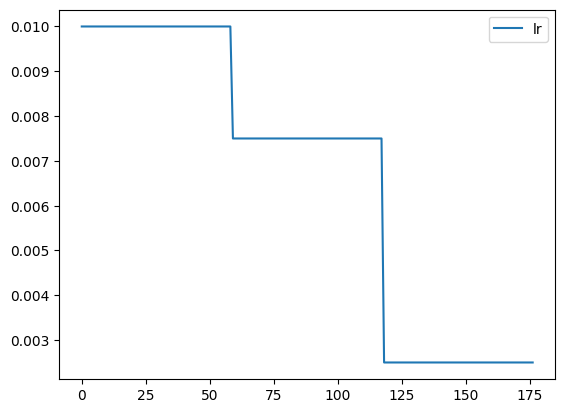

In [ ]:
record.plot()

## 1cycle training

In [ ]:
def get_beta1(pg):
    return pg["betas"][0]

In [ ]:
lr_scheduler.OneCycleLR?

Init signature:
lr_scheduler.OneCycleLR(
    optimizer,
    max_lr,
    total_steps=None,
    epochs=None,
    steps_per_epoch=None,
    pct_start=0.3,
    anneal_strategy='cos',
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
    div_factor=25.0,
    final_div_factor=10000.0,
    three_phase=False,
    last_epoch=-1,
    verbose=False,
)
Docstring:     
Sets the learning rate of each parameter group according to the
1cycle learning rate policy. The 1cycle policy anneals the learning
rate from an initial learning rate to some maximum learning rate and then
from that maximum learning rate to some minimum learning rate much lower
than the initial learning rate.
This policy was initially described in the paper `Super-Convergence:
Very Fast Training of Neural Networks Using Large Learning Rates`_.

The 1cycle learning rate policy changes the learning rate after every batch.
`step` should be called after a batch has been used for training.

This scheduler is not chai

accuracy,loss,epoch,train
0.776,0.622,0,train
0.844,0.459,0,valid
0.860,0.384,1,train
0.862,0.400,1,valid
0.883,0.316,2,train
0.872,0.362,2,valid
0.898,0.277,3,train
0.884,0.322,3,valid
0.915,0.233,4,train
0.898,0.285,4,valid


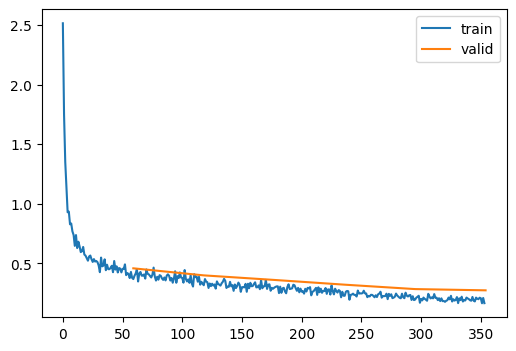

In [ ]:
epochs = 6
lr = 0.07
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
record = RecorderCB(lr=get_lr, beta1=get_beta1)

set_seed(1103)
model = get_model(act=act_init, norm=nn.BatchNorm2d)
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, record], opt_func=optim.AdamW)
learn.fit(epochs)

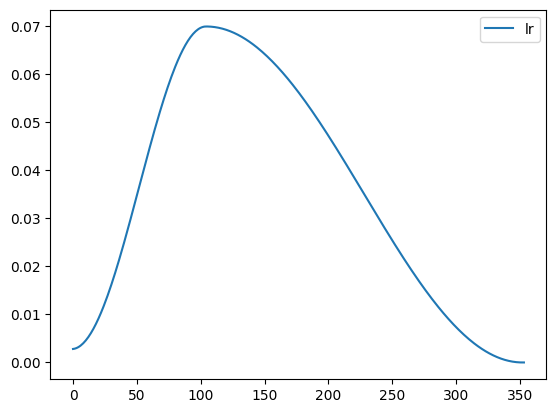

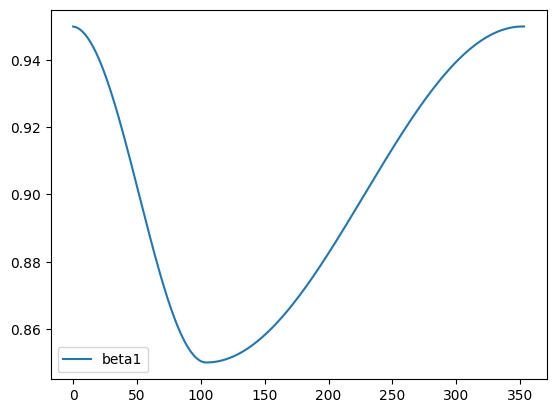

In [ ]:
record.plot()

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()